### SAR Image Despeckling Using a Convolutional Neural by ( 2 Jun 2017  ·  Puyang Wang, He Zhang, Vishal M. Patel)
### 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,BatchNormalization,LeakyReLU
import os
from skimage.util import random_noise
import sys
import time
from tqdm.notebook import tqdm
import shutil


In [3]:
INPUT_SIZE= (64,64)
BS=16
ROOT_DIR="/kaggle/"

### Preparing DATA
- I'm using a part of this DataSet: sentinel12-image-pairs-segregated-by-terrain
- From the Agriculture set I choose the optical set s2


In [4]:
DATASET=os.path.join(ROOT_DIR,'input/sentinel12-image-pairs-segregated-by-terrain/v_2')
DATA_GEN_INPUT=os.path.join(ROOT_DIR,'DATASET')

if os.path.exists(DATA_GEN_INPUT):
    shutil.rmtree(DATA_GEN_INPUT)
os.mkdir(DATA_GEN_INPUT)

src=os.path.join(DATASET,"agri/s2")
dst=os.path.join(DATA_GEN_INPUT,"DATA")
os.symlink(src,dst)

In [5]:
generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator=generator.flow_from_directory(DATA_GEN_INPUT,
                                              target_size=INPUT_SIZE,
                                              class_mode=None,
                                              color_mode='grayscale',
                                              batch_size=BS,
                                              follow_links=True,)

Found 4000 images belonging to 1 classes.


- This is how the data looks like

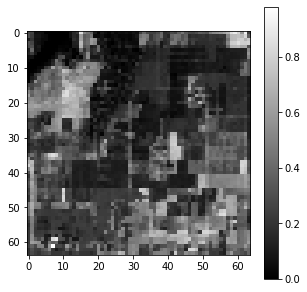

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(next(train_generator)[0],cmap='gray')
plt.colorbar()

### Testing Model

In [14]:

def test_model(data_generator):
    img1,img2=next(data_generator)[:2]
    noise_var=np.random.rand()*.25
    # noise_var=.3
    noisy_img1=random_noise(img1,mode='speckle',var=noise_var,clip=True)
    noisy_img2=random_noise(img2,mode='speckle',var=noise_var,clip=True)
    noisy_img1=np.expand_dims(noisy_img1,axis=[0,-1])
    noisy_img2=np.expand_dims(noisy_img2,axis=[0,-1])
    denoised_img1=model.predict(noisy_img1)
    denoised_img2=model.predict(noisy_img2)
    fig,ax=plt.subplots(3,2,figsize=(10,12))
    mapple=ax[0,0].imshow(img1)
    plt.colorbar(mapple,ax=ax[0,0])
    mapple=ax[0,1].imshow(img2)
    plt.colorbar(mapple,ax=ax[0,1])
    mapple=ax[1,0].imshow(noisy_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,0])
    mapple=ax[1,1].imshow(noisy_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,1])
    mapple=ax[2,0].imshow(denoised_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,0])
    mapple=ax[2,1].imshow(denoised_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,1])
    plt.show()

### Model Creation

In [8]:
def create_model(input_shape=(256,256,1)):
    input_layer=Input(shape=input_shape)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
    x=LeakyReLU(.2)(x)
#   Here I'm using dialation in convolution layers but in the original paper There are NO dialation used
    for i in range(1,5):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same',)(x)
        x=BatchNormalization()(x)
        x=LeakyReLU(.2)(x)
    for i in range(4,0,-1):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same')(x)
        x=BatchNormalization()(x)
        x=ReLU()(x)
    x=Conv2D(filters=1,kernel_size=(3,3),padding='same')(x)
    x=ReLU()(x) 
    x= tf.keras.layers.Lambda(lambda x:x+tf.constant(1e-7))(x)
    x=tf.math.divide(input_layer,x)

    x=tf.math.tanh(x)
    return tf.keras.Model(inputs=input_layer,outputs=x)
    

### The loss function 
-  I'm using MeanSquaredError and total_variation to implement the loss function 

In [9]:
MSE=tf.keras.losses.MeanSquaredError(reduction='none')
def loss_fn(y_true,y_pred,l_tv=.0002):
    mse=tf.reduce_sum(MSE(y_true,y_pred))
    variational_loss=tf.image.total_variation(y_pred)
    total_loss=mse+l_tv*variational_loss
    return tf.reduce_mean(total_loss),tf.reduce_mean(mse),tf.reduce_mean(variational_loss)
    

### Training 

In [15]:
@tf.function
def step(noisy_data, clean_data):
    with tf.GradientTape() as tape:
        pred = model(noisy_data)
        total_loss,loss_euclidian,loss_tv = loss_fn(clean_data, pred)
        loss=tf.add_n([total_loss],model.losses)
    grads = tape.gradient(total_loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss,loss_euclidian,loss_tv

In [16]:
model=create_model(list(INPUT_SIZE)+[1])

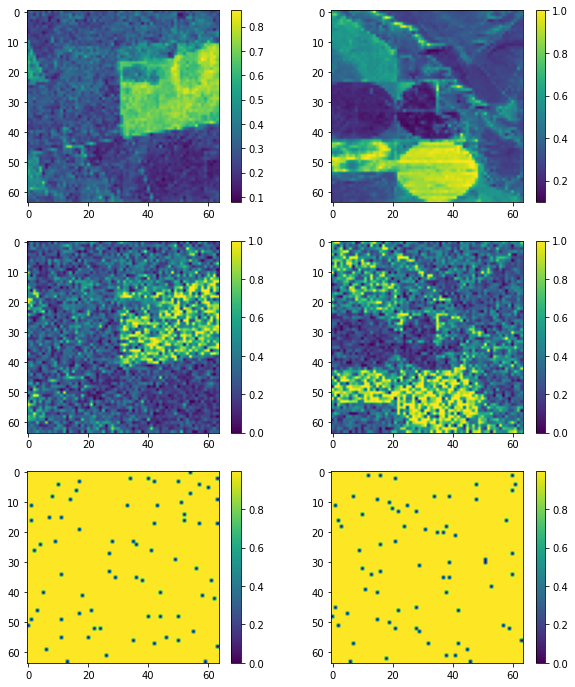

In [17]:
test_model(train_generator)

[INFO] starting epoch 1/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  18235.78125 loss_euclidian:  18235.65234375 loss_tv:  698.6735229492188


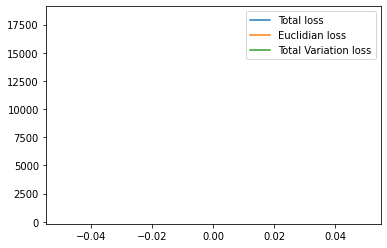

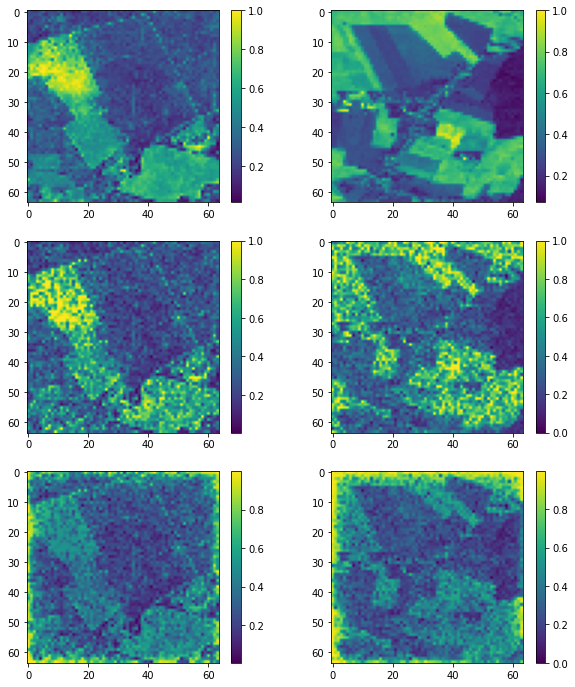

took 0.3256 minutes
[INFO] starting epoch 2/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  1504.387939453125 loss_euclidian:  1504.1678466796875 loss_tv:  1097.5047607421875
took 0.2875 minutes
[INFO] starting epoch 3/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  1112.6971435546875 loss_euclidian:  1112.47607421875 loss_tv:  1103.138916015625
took 0.2861 minutes
[INFO] starting epoch 4/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  1041.6474609375 loss_euclidian:  1041.435791015625 loss_tv:  1058.900390625
took 0.2881 minutes
[INFO] starting epoch 5/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  795.619384765625 loss_euclidian:  795.4592895507812 loss_tv:  797.5427856445312
took 0.2868 minutes
[INFO] starting epoch 6/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  720.396240234375 loss_euclidian:  720.2525024414062 loss_tv:  715.9647216796875


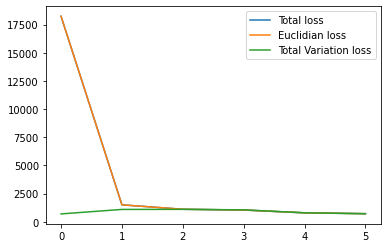

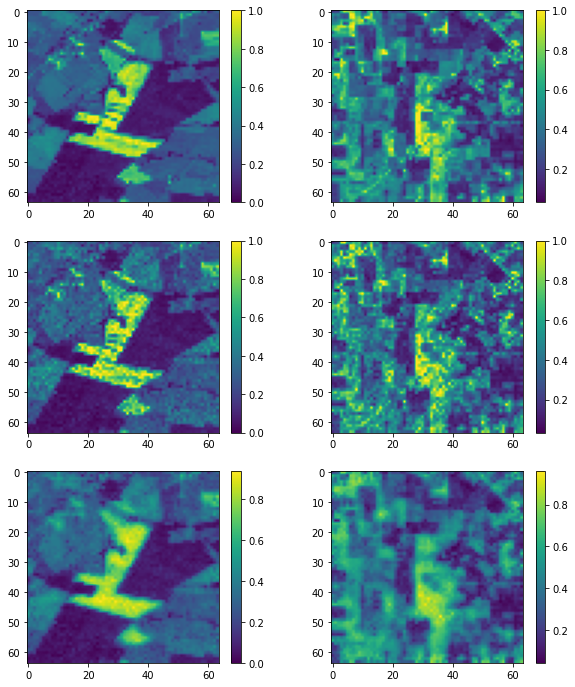

took 0.3178 minutes
[INFO] starting epoch 7/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  694.616455078125 loss_euclidian:  694.4786987304688 loss_tv:  687.2542724609375
took 0.2901 minutes
[INFO] starting epoch 8/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  658.0426635742188 loss_euclidian:  657.9116821289062 loss_tv:  656.9824829101562
took 0.284 minutes
[INFO] starting epoch 9/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  656.7227783203125 loss_euclidian:  656.5940551757812 loss_tv:  645.1624755859375
took 0.286 minutes
[INFO] starting epoch 10/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  676.9645385742188 loss_euclidian:  676.8358154296875 loss_tv:  643.59814453125
took 0.2864 minutes
[INFO] starting epoch 11/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  619.429931640625 loss_euclidian:  619.3065185546875 loss_tv:  616.2979125976562


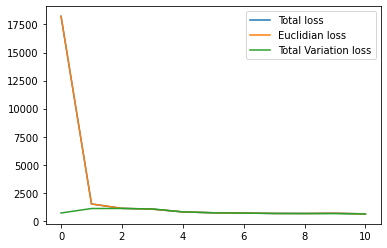

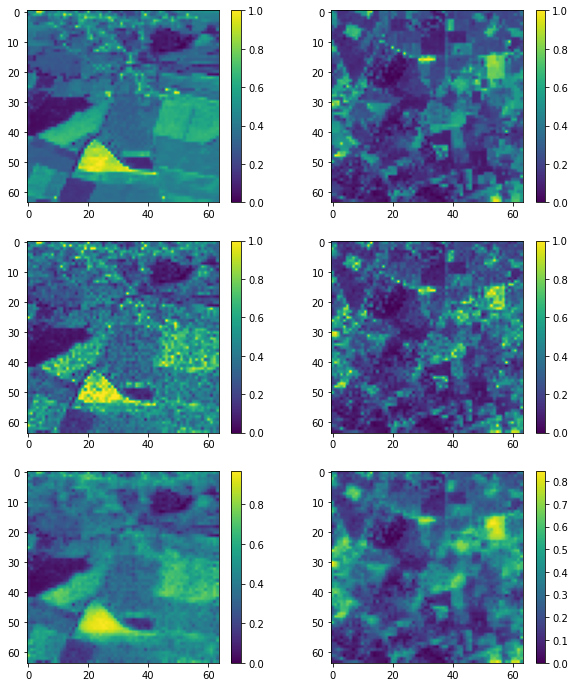

took 0.316 minutes
[INFO] starting epoch 12/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  652.7280883789062 loss_euclidian:  652.6038818359375 loss_tv:  624.8076782226562
took 0.2826 minutes
[INFO] starting epoch 13/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  636.1732788085938 loss_euclidian:  636.0505981445312 loss_tv:  613.1499633789062
took 0.291 minutes
[INFO] starting epoch 14/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  627.3181762695312 loss_euclidian:  627.1966552734375 loss_tv:  607.2520141601562
took 0.2789 minutes
[INFO] starting epoch 15/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  603.0016479492188 loss_euclidian:  602.8817138671875 loss_tv:  598.41943359375
took 0.2884 minutes
[INFO] starting epoch 16/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  603.0510864257812 loss_euclidian:  602.93212890625 loss_tv:  594.7114868164062


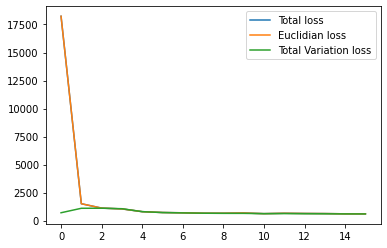

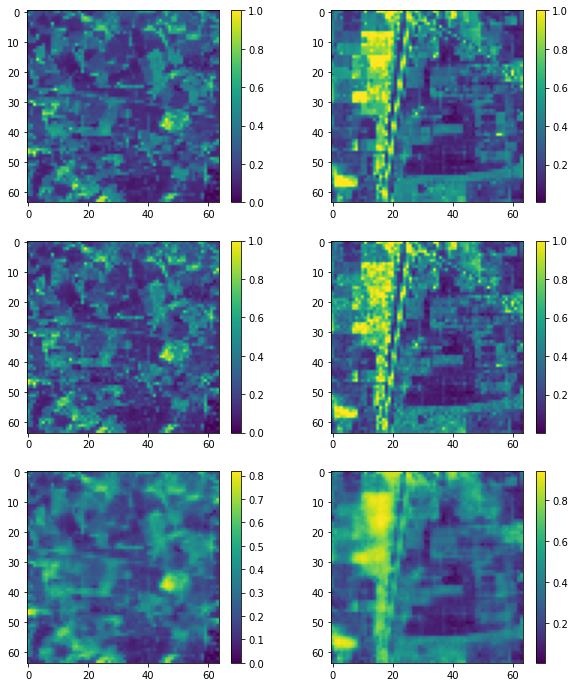

took 0.3046 minutes
[INFO] starting epoch 17/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  617.5694580078125 loss_euclidian:  617.449951171875 loss_tv:  597.9130859375
took 0.2878 minutes
[INFO] starting epoch 18/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  584.1774291992188 loss_euclidian:  584.0596923828125 loss_tv:  587.404296875
took 0.2862 minutes
[INFO] starting epoch 19/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  618.6860961914062 loss_euclidian:  618.566650390625 loss_tv:  596.8025512695312
took 0.2873 minutes
[INFO] starting epoch 20/20 , learning_rate 0.019999999552965164

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  610.2316284179688 loss_euclidian:  610.1126098632812 loss_tv:  594.5831298828125
took 0.2876 minutes


In [18]:
EPOCHS = 20 # The paper has trained the model for 2000 epochs
lr=2e-2
max_var=.3

opt = tf.keras.optimizers.Adadelta(learning_rate=lr) # in the paper Adam optimizer with lr=2e-5 ,beta_1=.5 is used but I found this one converging faster
train_loss=[]
n_instances=train_generator.n
numUpdates = int(n_instances / BS)
# loop over the number of epochs
for epoch in range(0, EPOCHS):
    lr=opt.learning_rate.numpy()
    # show the current epoch number
    print("[INFO] starting epoch {}/{} , learning_rate {}".format(
        epoch + 1, EPOCHS,lr), end="")
    sys.stdout.flush()
    epochStart = time.time()
    loss = 0
    loss_batch = []
    for i in tqdm(range(0, numUpdates)):
        clean_data = next(train_generator)
#         I Use Speckle Noise with Random Variance you can try a constant variance 
        noisy_data=random_noise(clean_data,mode='speckle',var=np.random.uniform(high=max_var))
        loss = step(noisy_data,clean_data)
        loss_batch.append((loss))
    loss_batch = np.array(loss_batch)
    loss_batch = np.sum(loss_batch, axis=0) / len(loss_batch)
    total_loss,loss_euclidian,loss_tv=loss_batch
    train_loss.append(loss_batch)
    print('\nTraining_loss # ', 'total loss: ', float(total_loss),
          'loss_euclidian: ', float(loss_euclidian),
          'loss_tv: ', float(loss_tv),)
    if epoch % 5==0:
        plt.plot(train_loss)
        plt.legend(['Total loss','Euclidian loss','Total Variation loss'])
        plt.show()
        test_model(train_generator)
    sys.stdout.flush()
    # show timing information for the epoch
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("took {:.4} minutes".format(elapsed))

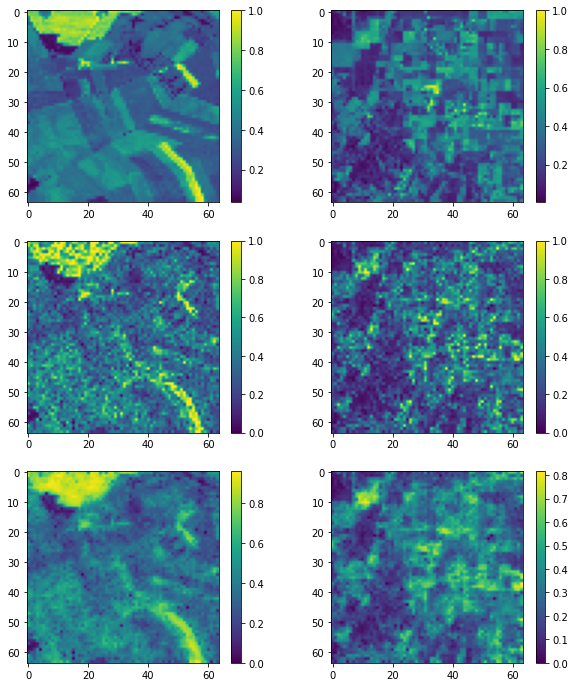

In [19]:
test_model(train_generator)